In [1]:
import torch

In [2]:
device = torch.device("mps")

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
from sklearn.cluster import KMeans,AgglomerativeClustering
from statistics import mode
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier

In [4]:
iber = pd.read_excel('Iberdrola 2010-24.xls')
df = iber

In [5]:
df.loc[:,'cerrar'] = iber.loc[:,'cerrar']/15

In [6]:
df

,Fecha,cerrar
0,2010-01-04,0.435173
1,2010-01-05,0.435693
2,2010-01-06,0.435113
3,2010-01-07,0.432333
4,2010-01-08,0.431880
...,...,...
3817,2024-11-20,0.890000
3818,2024-11-21,0.888333
3819,2024-11-22,0.905667
3820,2024-11-25,0.893333


In [7]:
n_steps = 20
df.set_index('Fecha', inplace=True)
for i in range(1, n_steps+1):
    df[f'cerrar(t-{i})'] = df['cerrar'].shift(i)
df.dropna(inplace=True)

In [8]:
df

,cerrar,cerrar(t-1),cerrar(t-2),cerrar(t-3),cerrar(t-4),cerrar(t-5),cerrar(t-6),cerrar(t-7),cerrar(t-8),cerrar(t-9),...,cerrar(t-11),cerrar(t-12),cerrar(t-13),cerrar(t-14),cerrar(t-15),cerrar(t-16),cerrar(t-17),cerrar(t-18),cerrar(t-19),cerrar(t-20)
Fecha,,,,,,,,,,,,,,,,,,,,,
2010-02-01,0.400967,0.399613,0.397413,0.404980,0.410473,0.406080,0.410733,0.414613,0.420307,0.430200,...,0.425480,0.431100,0.431687,0.431620,0.431940,0.431880,0.432333,0.435113,0.435693,0.435173
2010-02-02,0.404400,0.400967,0.399613,0.397413,0.404980,0.410473,0.406080,0.410733,0.414613,0.420307,...,0.427613,0.425480,0.431100,0.431687,0.431620,0.431940,0.431880,0.432333,0.435113,0.435693
2010-02-03,0.400520,0.404400,0.400967,0.399613,0.397413,0.404980,0.410473,0.406080,0.410733,0.414613,...,0.430200,0.427613,0.425480,0.431100,0.431687,0.431620,0.431940,0.431880,0.432333,0.435113
2010-02-04,0.381633,0.400520,0.404400,0.400967,0.399613,0.397413,0.404980,0.410473,0.406080,0.410733,...,0.420307,0.430200,0.427613,0.425480,0.431100,0.431687,0.431620,0.431940,0.431880,0.432333
2010-02-05,0.377627,0.381633,0.400520,0.404400,0.400967,0.399613,0.397413,0.404980,0.410473,0.406080,...,0.414613,0.420307,0.430200,0.427613,0.425480,0.431100,0.431687,0.431620,0.431940,0.431880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-20,0.890000,0.893333,0.888667,0.892667,0.891333,0.880333,0.879000,0.891000,0.880667,0.874000,...,0.916333,0.914667,0.921667,0.909667,0.917333,0.927333,0.938000,0.930000,0.935000,0.936000
2024-11-21,0.888333,0.890000,0.893333,0.888667,0.892667,0.891333,0.880333,0.879000,0.891000,0.880667,...,0.877667,0.916333,0.914667,0.921667,0.909667,0.917333,0.927333,0.938000,0.930000,0.935000
2024-11-22,0.905667,0.888333,0.890000,0.893333,0.888667,0.892667,0.891333,0.880333,0.879000,0.891000,...,0.874000,0.877667,0.916333,0.914667,0.921667,0.909667,0.917333,0.927333,0.938000,0.930000


In [9]:
from torch.utils.data import Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
y=np.array(df.iloc[:,0])
X=np.array(df.iloc[:,1:])

In [12]:
X.shape, y.shape

((3802, 20), (3802,))

In [13]:
X_train_cpu, X_test_cpu, y_train_cpu, y_test_cpu = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [14]:
import torch

In [15]:
X_train = torch.unsqueeze(torch.from_numpy(X_train_cpu).to(torch.float32),dim=-1).to(device)
X_test = torch.unsqueeze(torch.from_numpy(X_test_cpu).to(torch.float32),dim=-1).to(device)
y_train = torch.unsqueeze(torch.from_numpy(y_train_cpu).to(torch.float32),dim=-1).to(device)
y_test = torch.unsqueeze(torch.from_numpy(y_test_cpu).to(torch.float32),dim=-1).to(device)


In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([2547, 20, 1]),
 torch.Size([1255, 20, 1]),
 torch.Size([2547, 1]),
 torch.Size([1255, 1]))

In [17]:
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [18]:
from torch.utils.data import DataLoader
batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Red de Elman 

In [19]:
import torch.nn as nn

In [20]:
for x_batch, y_batch in train_loader:
    hidden_layer_size = 5
    h = torch.zeros(2, x_batch.shape[1], hidden_layer_size).to(device)
    modelo = nn.RNN(input_size=1,
        hidden_size=hidden_layer_size, num_layers=2).to(device)
    output, h = modelo(x_batch, h)
    break
output, h, output.shape, h.shape

(tensor([[[-0.5648, -0.4776, -0.5102, -0.3498, -0.1669],
          [-0.5646, -0.4773, -0.5099, -0.3494, -0.1667],
          [-0.5642, -0.4765, -0.5091, -0.3481, -0.1662],
          [-0.5636, -0.4755, -0.5081, -0.3465, -0.1655],
          [-0.5635, -0.4753, -0.5079, -0.3462, -0.1654],
          [-0.5639, -0.4759, -0.5085, -0.3472, -0.1658],
          [-0.5636, -0.4754, -0.5080, -0.3465, -0.1655],
          [-0.5634, -0.4750, -0.5076, -0.3457, -0.1652],
          [-0.5644, -0.4768, -0.5094, -0.3486, -0.1664],
          [-0.5650, -0.4779, -0.5106, -0.3504, -0.1672],
          [-0.5648, -0.4777, -0.5104, -0.3500, -0.1670],
          [-0.5653, -0.4785, -0.5112, -0.3513, -0.1676],
          [-0.5650, -0.4780, -0.5107, -0.3506, -0.1673],
          [-0.5647, -0.4775, -0.5102, -0.3497, -0.1669],
          [-0.5652, -0.4783, -0.5110, -0.3510, -0.1675],
          [-0.5651, -0.4781, -0.5108, -0.3507, -0.1673],
          [-0.5654, -0.4787, -0.5114, -0.3517, -0.1677],
          [-0.5651, -0.4783, -0

In [21]:
class elman(nn.Module):
    def __init__(self, input_size=1, hidden_size=5, num_layers=1, output_size=1):
        super().__init__()
        self.input_size=input_size
        self.hidden_size = hidden_size
        self.num_layers =num_layers
        
        self.hidden_layer = nn.RNN(input_size=self.input_size, hidden_size =self.hidden_size, num_layers=self.num_layers,batch_first=True)
        self.output_layer = nn.Linear(self.hidden_size, output_size)
        
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        out, h = self.hidden_layer(x, h0)
        output = self.output_layer(out[:, -1, :])
        return output

In [22]:
model = elman(input_size=1, hidden_size=5, num_layers=2, output_size=1).to(device)
model

elman(
  (hidden_layer): RNN(1, 5, num_layers=2, batch_first=True)
  (output_layer): Linear(in_features=5, out_features=1, bias=True)
)

In [23]:
from torchsummary import summary

In [24]:
learning_rate = 0.001
num_epochs = 50
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    accuracy = 0.0
    for x_batch, y_batch in tqdm(train_loader):
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        
        err = np.abs(output.detach().numpy()-y_batch.numpy())/y_batch.numpy()
        accuracy += np.mean(err<=0.05)
        
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return running_loss/len(train_loader), accuracy/len(train_loader)

In [26]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    accuracy = 0.0
    
    for x_batch, y_batch in test_loader:
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            err = np.abs(output.detach().numpy()-y_batch.numpy())/y_batch.numpy()
            accuracy += np.mean(err<=0.05)
            running_loss += loss.item()
    return running_loss / len(test_loader), accuracy/len(test_loader)

In [27]:
from tqdm import tqdm

In [28]:
resultados=pd.DataFrame(columns=["Loss_train","Loss_test","Acc_train","Acc_test"])

In [29]:
for epoch in range(num_epochs):
    val_train,a_train=train_one_epoch()
    val_test,a_test=validate_one_epoch()
    
    resultados.loc[epoch]=(val_train,val_test,a_train,a_test)

Epoch: 1


100%|██████████████████████████████████████| 2547/2547 [00:02<00:00, 889.38it/s]


Epoch: 2


100%|██████████████████████████████████████| 2547/2547 [00:02<00:00, 926.13it/s]


Epoch: 3


100%|██████████████████████████████████████| 2547/2547 [00:02<00:00, 941.14it/s]


Epoch: 4


100%|██████████████████████████████████████| 2547/2547 [00:02<00:00, 942.85it/s]


Epoch: 5


100%|██████████████████████████████████████| 2547/2547 [00:02<00:00, 904.01it/s]


Epoch: 6


100%|██████████████████████████████████████| 2547/2547 [00:02<00:00, 935.15it/s]


Epoch: 7


100%|██████████████████████████████████████| 2547/2547 [00:02<00:00, 918.61it/s]


Epoch: 8


100%|██████████████████████████████████████| 2547/2547 [00:02<00:00, 916.27it/s]


Epoch: 9


100%|██████████████████████████████████████| 2547/2547 [00:02<00:00, 912.59it/s]


Epoch: 10


100%|██████████████████████████████████████| 2547/2547 [00:02<00:00, 937.93it/s]


Epoch: 11


100%|██████████████████████████████████████| 2547/2547 [00:02<00:00, 936.80it/s]


Epoch: 12


100%|██████████████████████████████████████| 2547/2547 [00:02<00:00, 942.04it/s]


Epoch: 13


100%|██████████████████████████████████████| 2547/2547 [00:02<00:00, 944.90it/s]


Epoch: 14


100%|██████████████████████████████████████| 2547/2547 [00:02<00:00, 942.82it/s]


Epoch: 15


100%|██████████████████████████████████████| 2547/2547 [00:02<00:00, 921.37it/s]


Epoch: 16


100%|██████████████████████████████████████| 2547/2547 [00:02<00:00, 913.47it/s]


Epoch: 17


100%|██████████████████████████████████████| 2547/2547 [00:02<00:00, 883.74it/s]


Epoch: 18


100%|██████████████████████████████████████| 2547/2547 [00:02<00:00, 925.33it/s]


Epoch: 19


100%|██████████████████████████████████████| 2547/2547 [00:02<00:00, 907.53it/s]


Epoch: 20


100%|██████████████████████████████████████| 2547/2547 [00:02<00:00, 900.68it/s]


Epoch: 21


100%|██████████████████████████████████████| 2547/2547 [00:02<00:00, 897.56it/s]


Epoch: 22


100%|██████████████████████████████████████| 2547/2547 [00:02<00:00, 902.53it/s]


Epoch: 23


100%|██████████████████████████████████████| 2547/2547 [00:02<00:00, 902.85it/s]


Epoch: 24


100%|██████████████████████████████████████| 2547/2547 [00:02<00:00, 924.43it/s]


Epoch: 25


100%|██████████████████████████████████████| 2547/2547 [00:02<00:00, 925.46it/s]


Epoch: 26


100%|██████████████████████████████████████| 2547/2547 [00:02<00:00, 944.82it/s]


Epoch: 27


  8%|███▏                                   | 205/2547 [00:00<00:02, 939.02it/s]


KeyboardInterrupt: 

In [30]:
resultados

,Loss_train,Loss_test,Acc_train,Acc_test
0,0.003447,0.000821,0.537888,0.645418
1,0.001069,0.001198,0.589713,0.519522
2,0.001037,0.001095,0.600314,0.545817
3,0.000980,0.000981,0.612093,0.637450
4,0.000969,0.001157,0.614056,0.551394
5,0.000999,0.001227,0.603848,0.403984
6,0.001009,0.000835,0.605811,0.676494
7,0.000978,0.000956,0.613663,0.619124
8,0.000986,0.000997,0.610522,0.639044
9,0.000999,0.000972,0.612878,0.631873


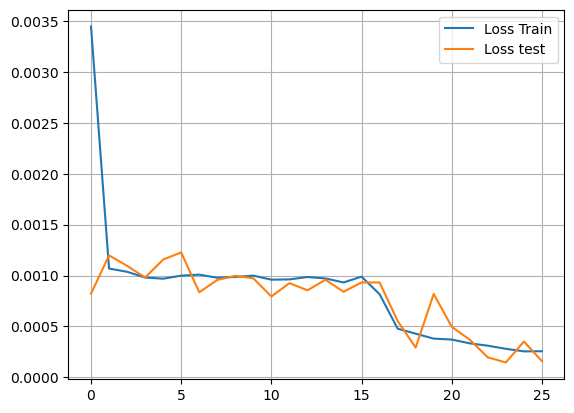

In [35]:
plt.plot(range(len(resultados)),resultados.iloc[:,0],resultados.iloc[:,1])
plt.grid()
plt.legend(labels=["Loss Train","Loss test"])

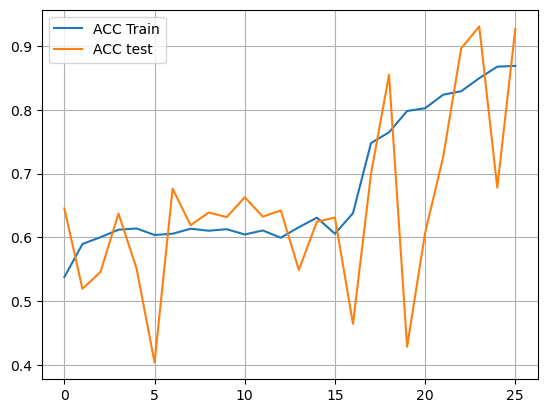

In [36]:
plt.plot(range(len(resultados)),resultados.iloc[:,2],resultados.iloc[:,3])
plt.grid()
plt.legend(labels=["ACC Train","ACC test"])

## LSTM

In [37]:
class LSTM_class(nn.Module):
    def __init__(self, input_size=1, hidden_size=5, num_layers=1, output_size=1):
        super().__init__()
        self.input_size=input_size
        self.hidden_size = hidden_size
        self.num_layers =num_layers
        
        self.hidden_layer = nn.LSTM(input_size=self.input_size, hidden_size =self.hidden_size, num_layers=self.num_layers,batch_first=True)
        self.output_layer = nn.Linear(self.hidden_size, output_size)
        
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers,batch_size,self.hidden_size).to(device)
        out, (h,c) = self.hidden_layer(x, (h0,c0))
        output = self.output_layer(out[:, -1, :])
        return output

In [38]:
model = LSTM_class(input_size=1, hidden_size=5, num_layers=2, output_size=1).to(device)

In [39]:
learning_rate = 0.001
num_epochs = 50
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [40]:
resultados=pd.DataFrame(columns=["Loss_train","Loss_test","Acc_train","Acc_test"])

In [41]:
for epoch in range(num_epochs):
    val_train,a_train=train_one_epoch()
    val_test,a_test=validate_one_epoch()
    
    resultados.loc[epoch]=(val_train,val_test,a_train,a_test)

Epoch: 1


100%|██████████████████████████████████████| 2547/2547 [00:06<00:00, 422.79it/s]


Epoch: 2


 14%|█████▎                                 | 347/2547 [00:00<00:05, 421.63it/s]


KeyboardInterrupt: 

In [ ]:
resultados

In [ ]:
plt.plot(range(num_epochs),resultados.iloc[:,0],resultados.iloc[:,1])
plt.grid()
plt.legend(labels=["Loss Train","Loss test"])

In [ ]:
plt.plot(range(50),resultados.iloc[:,2],resultados.iloc[:,3])
plt.grid()
plt.legend(labels=["ACC Train","ACC test"])

In [ ]:
np.max(resultados.iloc[:,3])

## GRU

In [ ]:
class GRU_class(nn.Module):
    def __init__(self, input_size=1, hidden_size=5, num_layers=1, output_size=1):
        super().__init__()
        self.input_size=input_size
        self.hidden_size = hidden_size
        self.num_layers =num_layers
        
        self.hidden_layer = nn.GRU(input_size=self.input_size, hidden_size =self.hidden_size, num_layers=self.num_layers,batch_first=True)
        self.output_layer = nn.Linear(self.hidden_size, output_size)
        
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        out, h = self.hidden_layer(x, h0)
        output = self.output_layer(out[:, -1, :])
        return output

In [ ]:
model = GRU_class(input_size=1, hidden_size=5, num_layers=2, output_size=1).to(device)

In [ ]:
learning_rate = 0.001
num_epochs = 50
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
resultados=pd.DataFrame(columns=["Loss_train","Loss_test","Acc_train","Acc_test"])

In [ ]:
for epoch in range(num_epochs):
    val_train,a_train=train_one_epoch()
    val_test,a_test=validate_one_epoch()
    
    resultados.loc[epoch]=(val_train,val_test,a_train,a_test)

In [ ]:
resultados

In [ ]:
plt.plot(range(num_epochs),resultados.iloc[:,0],resultados.iloc[:,1])
plt.grid()
plt.legend(labels=["Loss Train","Loss test"])

In [ ]:
plt.plot(range(50),resultados.iloc[:,2],resultados.iloc[:,3])
plt.grid()
plt.legend(labels=["ACC Train","ACC test"])

In [ ]:
np.max(resultados.iloc[:,3])